<a href="https://colab.research.google.com/github/EduardoLouvize/PD_LLM_3v2/blob/main/PD_LLM_3v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Instalação de dependências
!pip install --quiet transformers[torch] kagglehub wordcloud matplotlib seaborn

import pandas as pd
import datetime
import os
import kagglehub
from collections import Counter
from transformers import pipeline
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re
nltk.download('stopwords')
from nltk.corpus import stopwords

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 50.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 30.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 32.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 16.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 72.5 MB/s eta 0:00:00


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [2]:
# Baixar o dataset da Folha UOL
caminho_dataset = kagglehub.dataset_download("marlesson/news-of-the-site-folhauol")
df = pd.read_csv(os.path.join(caminho_dataset, "articles.csv"))

100%|██████████| 187M/187M [00:01<00:00, 119MB/s]

Extracting files...


In [3]:
# Filtrar pela seção "Mercado" no 1º trimestre de 2015
df = df.fillna("")
df["date"] = pd.to_datetime(df["date"])
df_mercado = df[df["category"].str.lower() == "mercado"].copy()
inicio_2015 = datetime.datetime(2015, 1, 1)
fim_2015_q1 = datetime.datetime(2015, 3, 31)
df_q1 = df_mercado[(df_mercado["date"] >= inicio_2015) & (df_mercado["date"] <= fim_2015_q1)].copy()

In [4]:
# Carregar modelo NER Hugging Face
modelo_nome = "monilouise/ner_pt_br"
pipeline_ner = pipeline("ner", model=modelo_nome, tokenizer=modelo_nome, aggregation_strategy="simple")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of the model checkpoint at monilouise/ner_pt_br were not used when initializing BertForTokenClassification: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


tokenizer_config.json:   0%|          | 0.00/529 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Device set to use cuda:0


In [5]:
# Função de extração com o modelo Hugging Face
def extrair_organizacoes(texto):
    entidades = pipeline_ner(texto)
    return [ent["word"].strip().lower() for ent in entidades if ent["entity_group"] == "ORG"]

In [6]:
# Aplicar extração
todas_organizacoes = []
for _, linha in df_q1.iterrows():
    todas_organizacoes.extend(extrair_organizacoes(linha["text"]))

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


In [7]:
# Contagem e ranking
contagem = Counter(todas_organizacoes)
ranking = contagem.most_common()

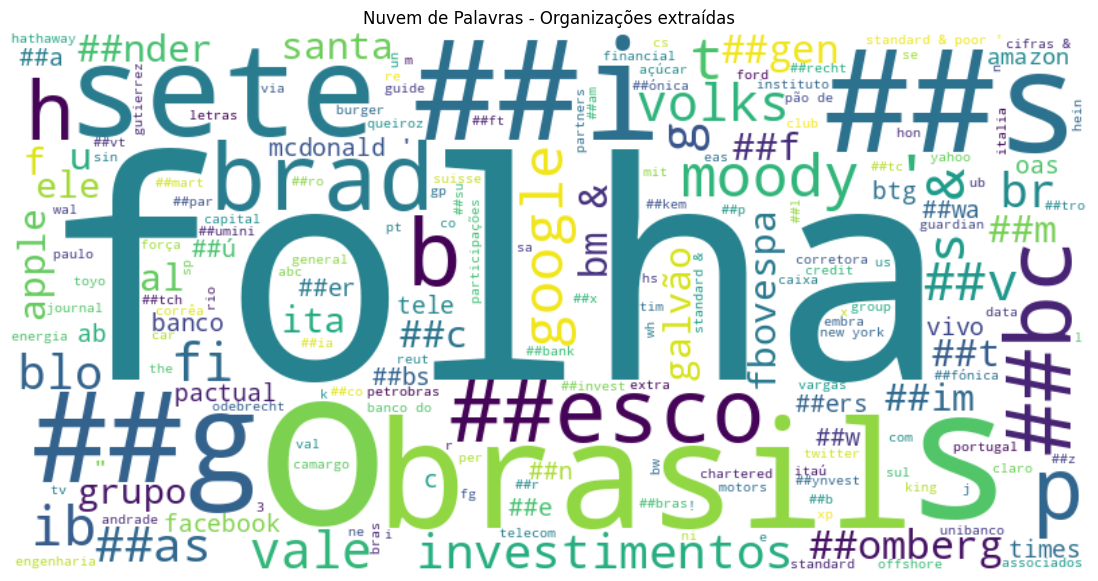

In [8]:
# Nuvem de palavras
nuvem = WordCloud(width=800, height=400, background_color="white").generate_from_frequencies(contagem)
plt.figure(figsize=(15, 7))
plt.imshow(nuvem, interpolation="bilinear")
plt.axis("off")
plt.title("Nuvem de Palavras - Organizações extraídas")
plt.show()

In [9]:
# Gráfico de barras (Top 20)
top_n = 20
top_orgaos = ranking[:top_n]
nomes = [org for org, _ in top_orgaos]
frequencias = [freq for _, freq in top_orgaos]

/tmp/ipython-input-10-30007535.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=frequencias, y=nomes, palette="viridis")


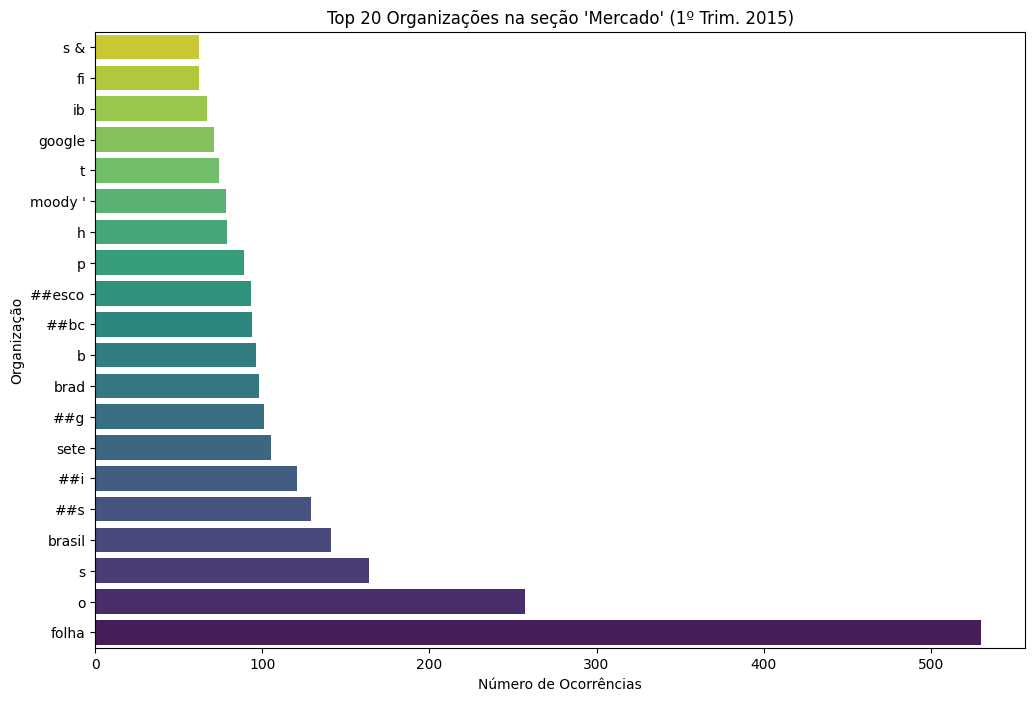

In [10]:
plt.figure(figsize=(12, 8))
sns.barplot(x=frequencias, y=nomes, palette="viridis")
plt.title(f"Top {top_n} Organizações na seção 'Mercado' (1º Trim. 2015)")
plt.xlabel("Número de Ocorrências")
plt.ylabel("Organização")
plt.gca().invert_yaxis()
plt.show()

In [11]:
# Instalar e carregar stopwords em português
import nltk
import re
nltk.download('stopwords')
from nltk.corpus import stopwords

stopwords_pt = set(stopwords.words("portuguese"))

def limpar_organizacao(org):
    # Remove caracteres especiais no início
    org = re.sub(r'^[^a-zA-Z0-9]+', '', org)
    # Verifica comprimento mínimo e se é uma stopword
    if len(org) < 2 or org.lower() in stopwords_pt:
        return None
    return org

# Aplicar limpeza
todas_organizacoes_limpo = [limpar_organizacao(org) for org in todas_organizacoes]
todas_organizacoes_filtradas = [org for org in todas_organizacoes_limpo if org]

# Recontar e atualizar visualizações
contagem = Counter(todas_organizacoes_filtradas)
ranking = contagem.most_common()


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


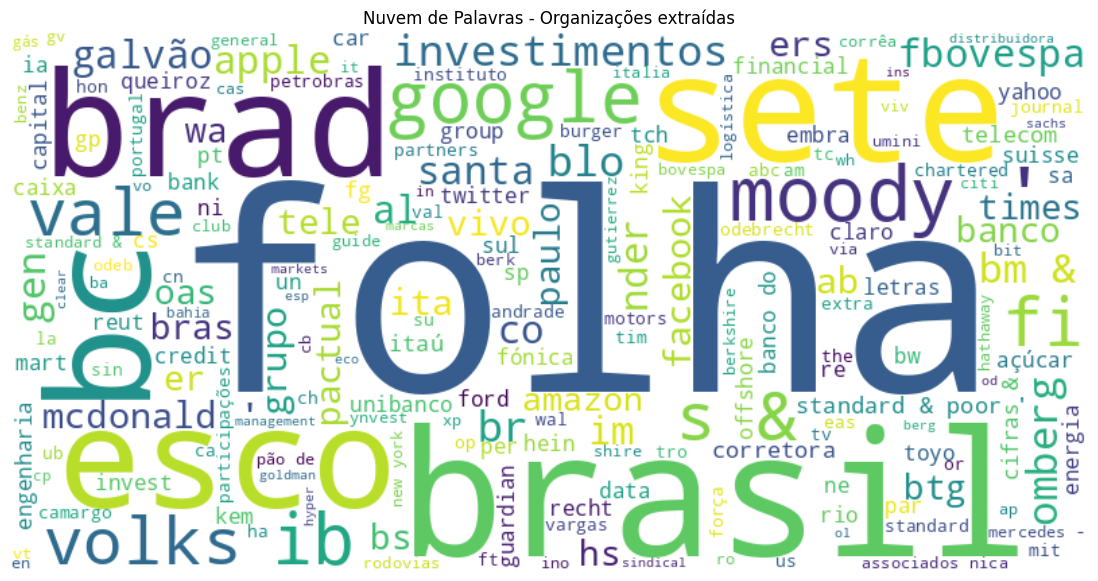

In [12]:
# Nuvem de palavras
nuvem = WordCloud(width=800, height=400, background_color="white").generate_from_frequencies(contagem)
plt.figure(figsize=(15, 7))
plt.imshow(nuvem, interpolation="bilinear")
plt.axis("off")
plt.title("Nuvem de Palavras - Organizações extraídas")
plt.show()

/tmp/ipython-input-13-30007535.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=frequencias, y=nomes, palette="viridis")


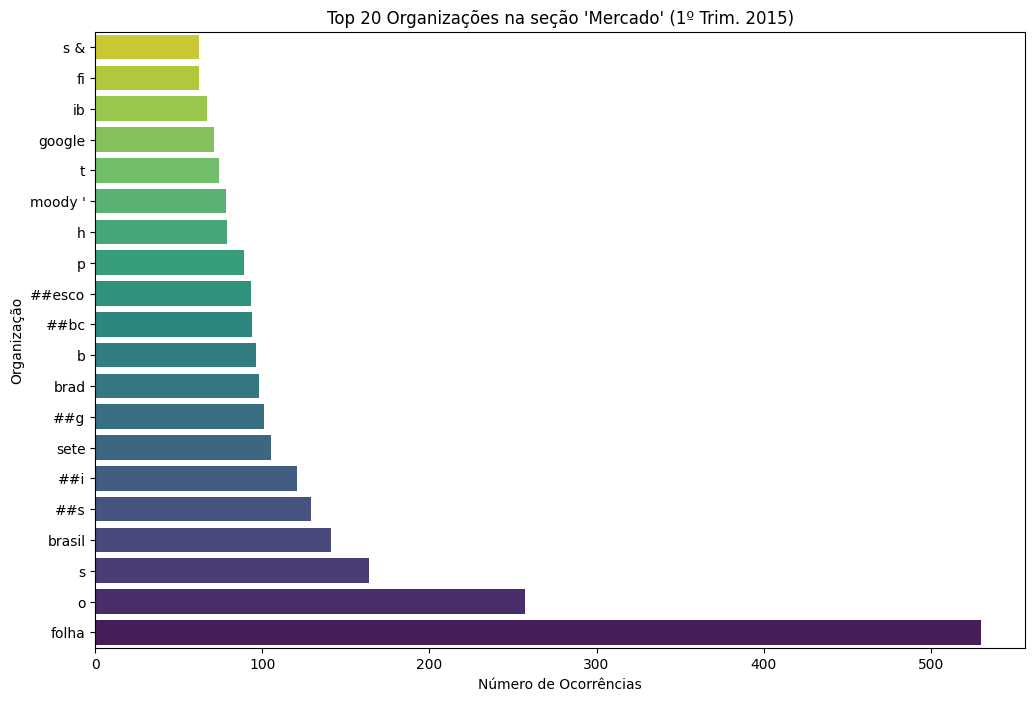

In [13]:
plt.figure(figsize=(12, 8))
sns.barplot(x=frequencias, y=nomes, palette="viridis")
plt.title(f"Top {top_n} Organizações na seção 'Mercado' (1º Trim. 2015)")
plt.xlabel("Número de Ocorrências")
plt.ylabel("Organização")
plt.gca().invert_yaxis()
plt.show()